# Variaciones del mismo digito


### En este notebook se observan distintas reconstrucciones del mismo dígito


#### Datos

Se usaron los datos de MNIST para entrenar los modelos y visualizar las variaciones por dígito (genericamente clase).


#### Modelo


Se usaron los modelos de diminesiones 128_2 y 256_128 (intermedia y latente respectivamente) para visualizar.


In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

import experiments.load as load


cvae_0 = load.cvae(lat=64,inter=128,dataset="mnist")

cvae_1 = load.cvae(inter=256,lat=128,dataset="mnist")

cvae_2 = load.cvae(lat=2, inter=128,dataset="mnist")

predictor = load.predictor("mnist")

data =  load.data("mnist")

x_train = data["x_train"]
x_train_1 = data["x_train_1"]
y_train = data["y_train"]
y_train_1 = data["y_train_1"]
x_test = data["x_test"]
y_test  =data["y_test"]

models = load.all_models()

2025-08-20 23:28:22.911776: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 23:28:22.915058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 23:28:22.926597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755743302.943907  824349 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755743302.948622  824349 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755743302.963118  824349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Usando mnist como dataset
Encontrados 12 pares de modelos.


## Visualizaciones:

Variaciones por dígito de cvae_0


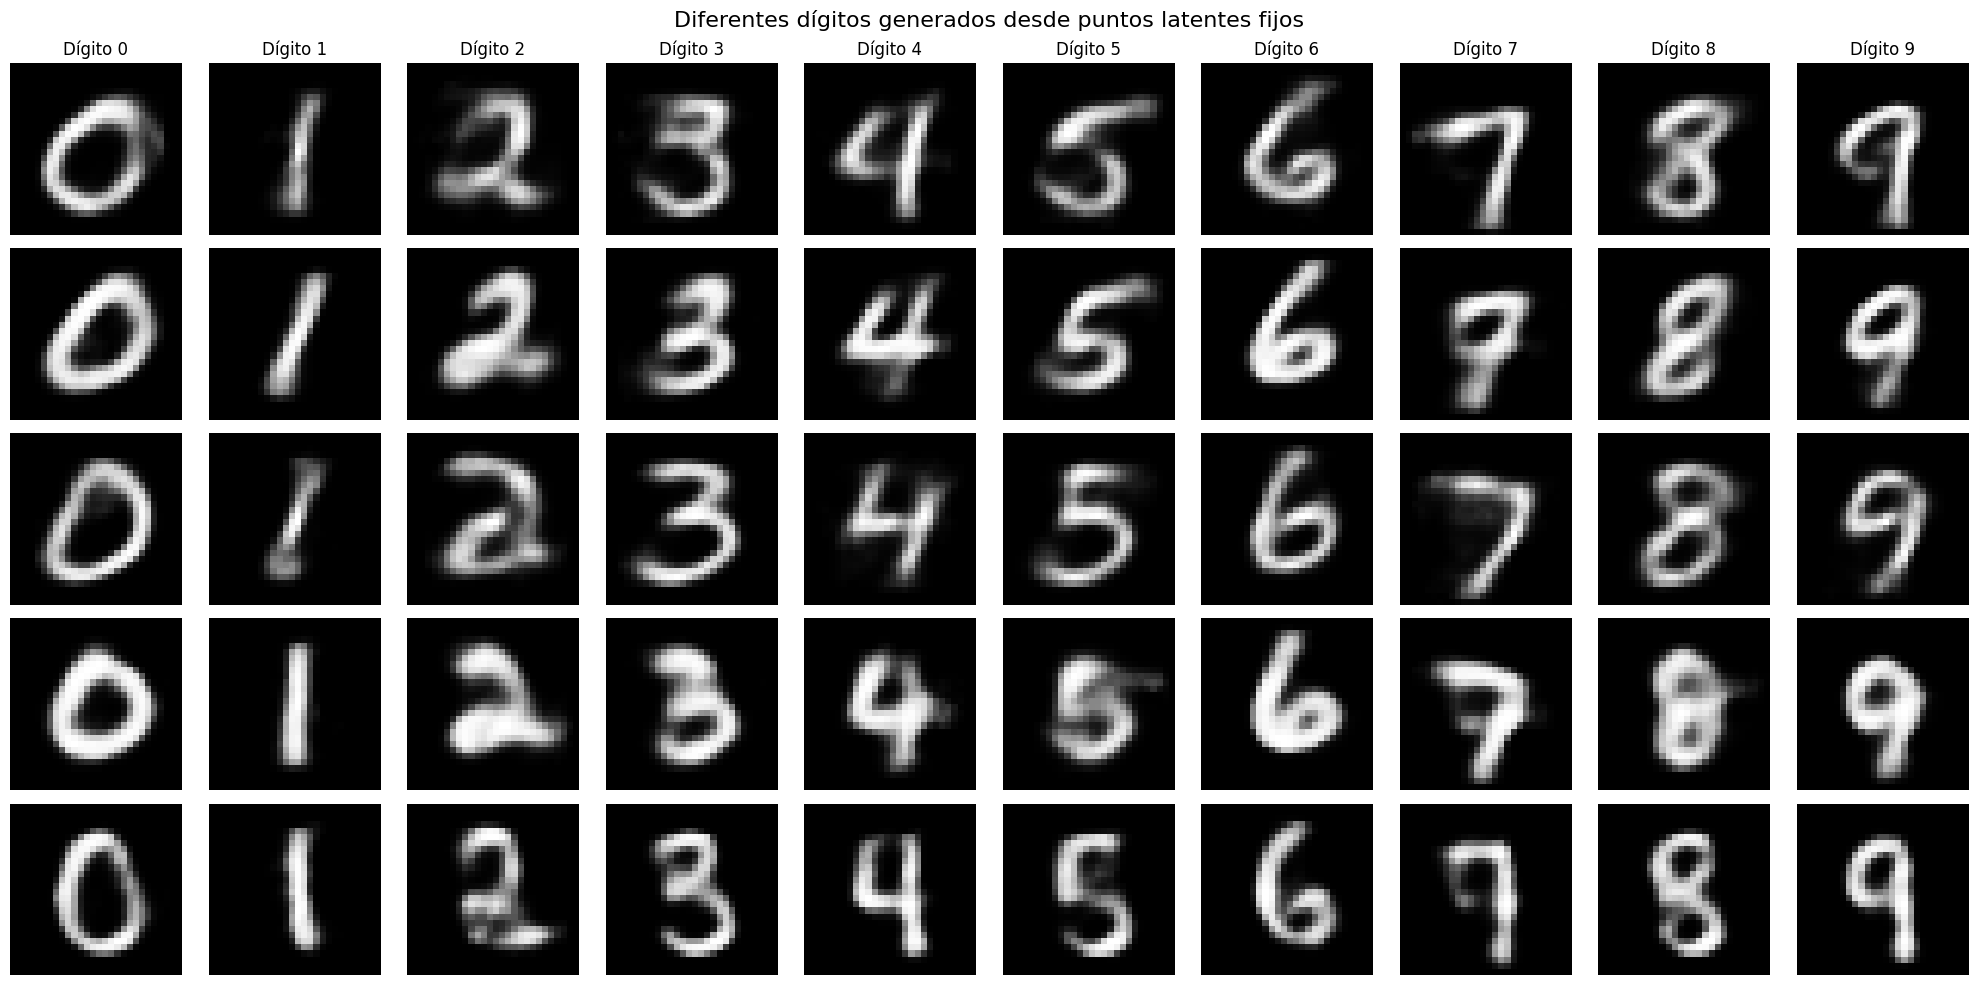

In [4]:
import visualizations.visualizations as vis

puntos=vis.variantes_punto_fijo(cvae=cvae_0)

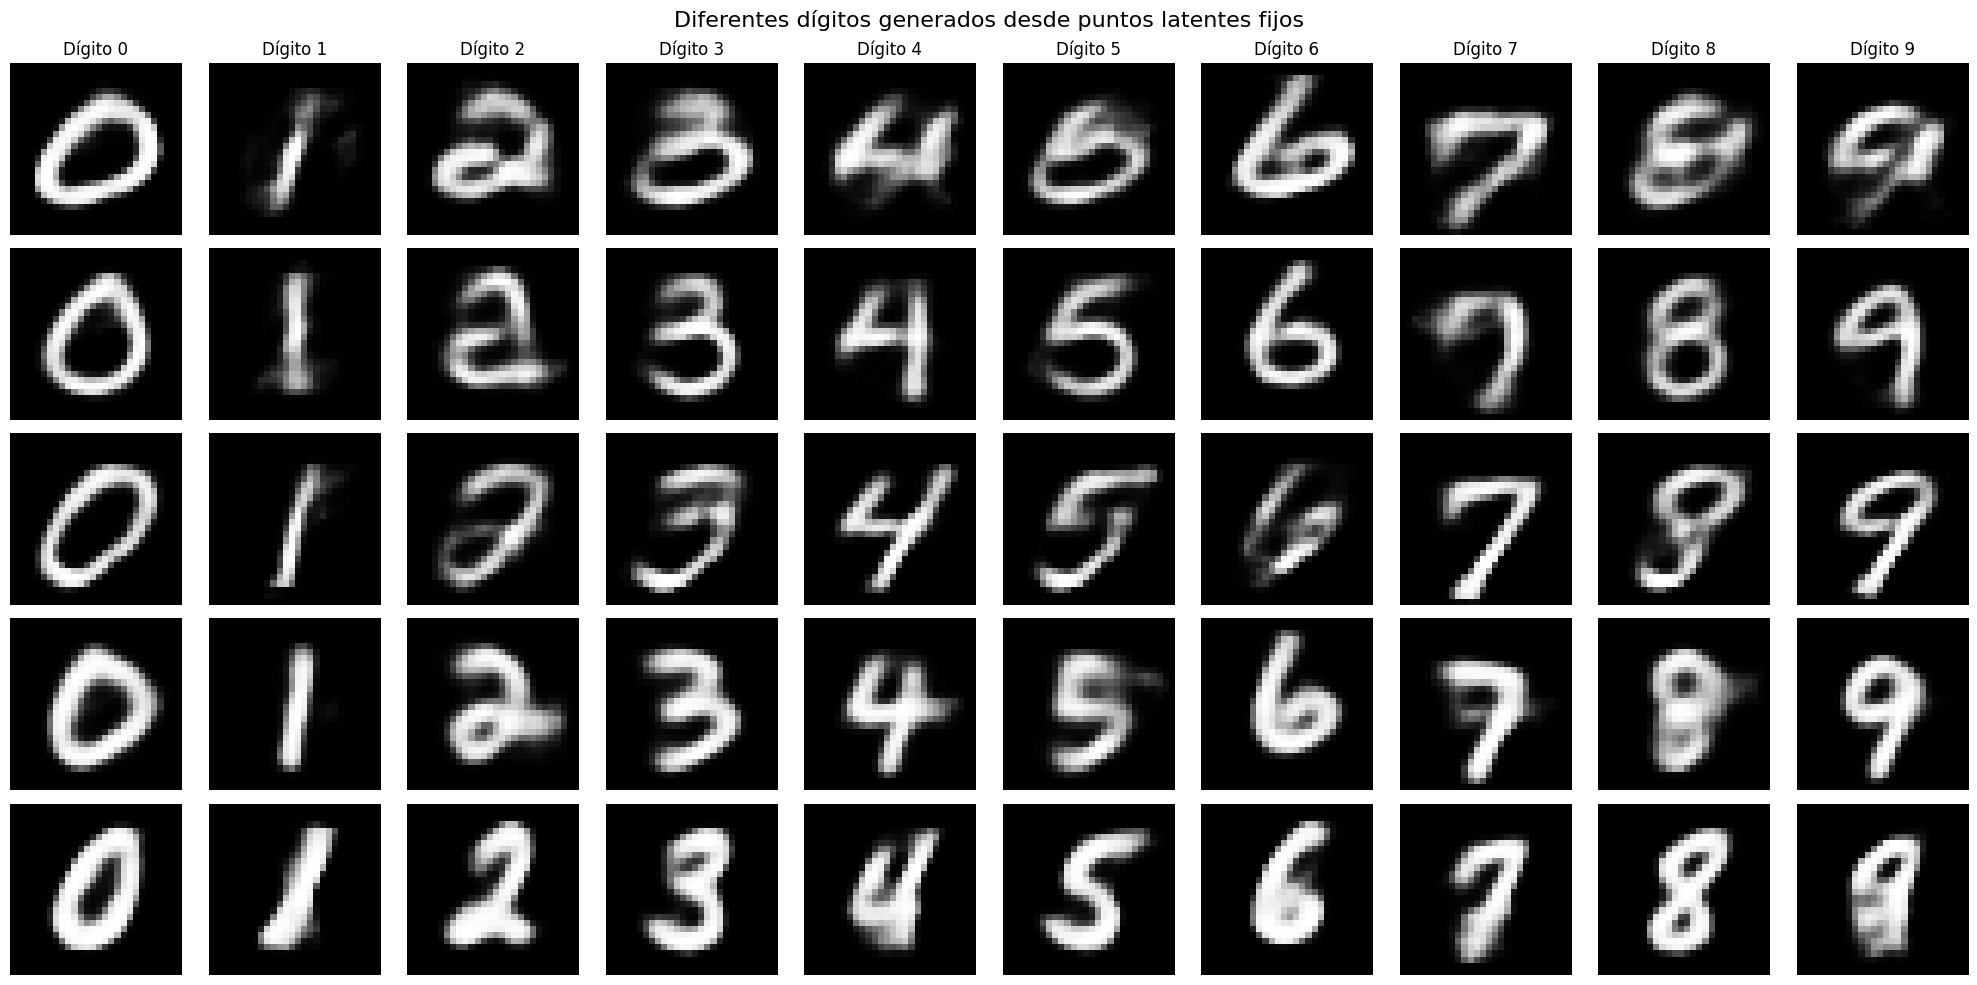

In [5]:
puntos=vis.variantes_punto_fijo(cvae=cvae_1)

Para ambos modelos parece haber una buena reconstruccion de dígitos. Bastante peor en el caso del modelo cvae_1 los modelos fueron entrenados hasta que earystop los freno.
¿Quizas es muy poco entrenamiento? quzias la paciencia del earystop es baja?



## Condiciones anómalas

condición en el decoder y enconder en 0 o aleatoreo


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


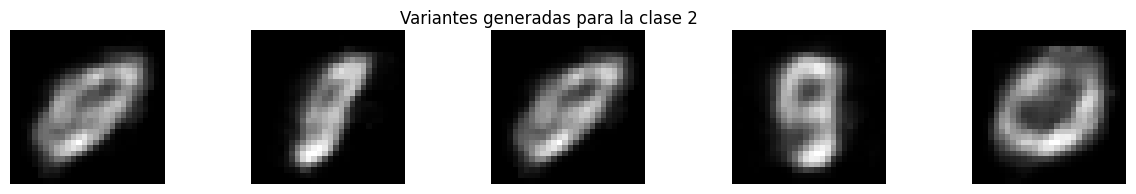

array([[ 0.39417763, -1.00142261],
       [-0.73690373, -0.56313894],
       [ 0.19681557, -1.05563993],
       [-0.12243235,  0.24259914],
       [ 1.26278914, -0.59982121]])

In [ ]:
import visualizaciones.visualizar as vis
import importlib
import numpy as np

importlib.reload(vis)
num_variantes = 5
custom_condition = np.zeros(shape=(num_variantes, 10))
# custom_condition = np.random.uniform(0,1,size=(num_variantes,10))
"""
1) probar poner 0s al encoder.

2) entrenar un encoder sin clases en la entrada (quizas ponerle 0 en la entrada, sino cambiar 
                                                la arquitectura para que no tenga condicion. Verficar si es lo mismo)


"""
print(custom_condition)
vis.variantes(
    cvae=cvae_0,
    condicion_id=2,
    num_variantes=num_variantes,
    custom_condition=custom_condition,
)

En ambos casos se observan figuras caoticas, se aprecia cierta estructura pero no es posible atribuir una clase a las imagenes


Metricas


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from collections import defaultdict


def evaluar_reconstruccion_por_clase(cvae, x_test, y_test, metric="mse"):
    """
    Evalúa la calidad de reconstrucción para cada clase.

    Args:
        cvae: modelo CVAE entrenado
        x_test: imágenes de prueba (shape: [N, 28, 28])
        y_test: etiquetas one-hot (shape: [N, 10])
        metric: 'mse' o 'bce'

    Returns:
        dict: promedio del error por clase
    """
    errores = defaultdict(list)

    for i in tqdm(range(len(x_test))):
        x = x_test[i : i + 1]  # (1, 28, 28)
        y = y_test[i : i + 1]  # (1, 10)

        # Codificar
        z_mean, _, z = cvae.encoder.predict([x, y], verbose=0)
        # Decodificar
        x_recon = cvae.decoder.predict([z, y], verbose=0)

        # Flatten para comparar
        x_flat = x.flatten()
        x_recon_flat = x_recon.flatten()

        if metric == "mse":
            error = mean_squared_error(x_flat, x_recon_flat)
        elif metric == "bce":
            import tensorflow.keras.losses as losses

            error = losses.binary_crossentropy(x_flat, x_recon_flat).numpy().mean()

        clase = np.argmax(y)
        errores[clase].append(error)

    # Promedio por clase
    resultados = {clase: np.mean(errores[clase]) for clase in errores}
    return resultados

Se usaron 1000 imagenes del dataset MNIST para evaluar el error de reconstrucción por dígito de cada modelo.
Se usan las imagenes originales y la reconstrución para calcular el error cuadratico medio entre ambas figuras.


In [ ]:

models = []
inter = [128,128, 256, 256 ,512 ,1024]
lat =   [2,  64 , 64 , 128 ,256 ,256]
dataset = "mnist"

models.append(load.cvae())

for i, l in zip(inter,lat):
    models.append(load.cvae(lat=l,inter=i,dataset=dataset),predictor=predictor,data=dataset)



# TODO: terminar esto y seguir refactorizando. Crear el modelo que falta de mnist, 
# ver que hacer con la funcion de cargar todo para que tenga nombres
resultados_0 = evaluar_reconstruccion_por_clase(
    cvae_0, x_test[0:1000], y_test[0:1000], metric="mse"
)
resultados_1 = evaluar_reconstruccion_por_clase(
    cvae_1, x_test[0:1000], y_test[0:1000], metric="mse"
)

for clase, error in sorted(resultados_0.items()):
    print(f"{cvae_0.name} Dígito {clase}: error promedio = {error:.3f}")

for clase, error in sorted(resultados_1.items()):
    print(f"{cvae_1.name} Dígito {clase}: error promedio = {error:.3f}")

100%|██████████| 10/10 [00:01<00:00,  8.58it/s]

----------------------------
cvae_laten_2_inter_128_mnist
resultados
0.03761300444602966
0.008281922899186611
0.060959164053201675


KeyError: 3

## Espacio latente de ambos modelos


C:\Users\galan\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


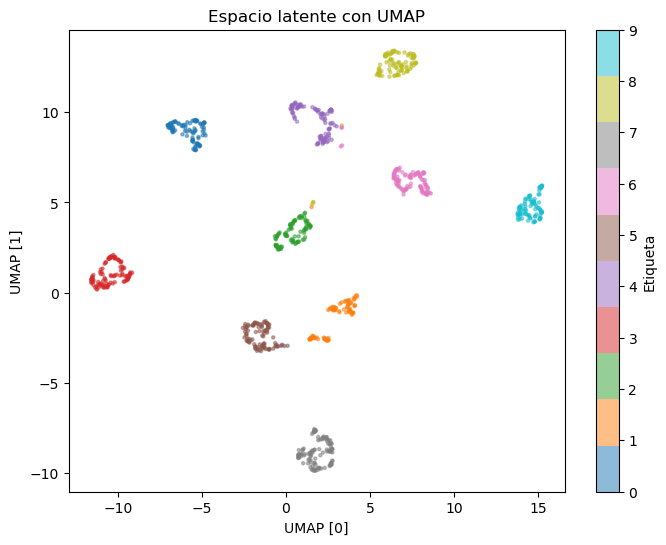

C:\Users\galan\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


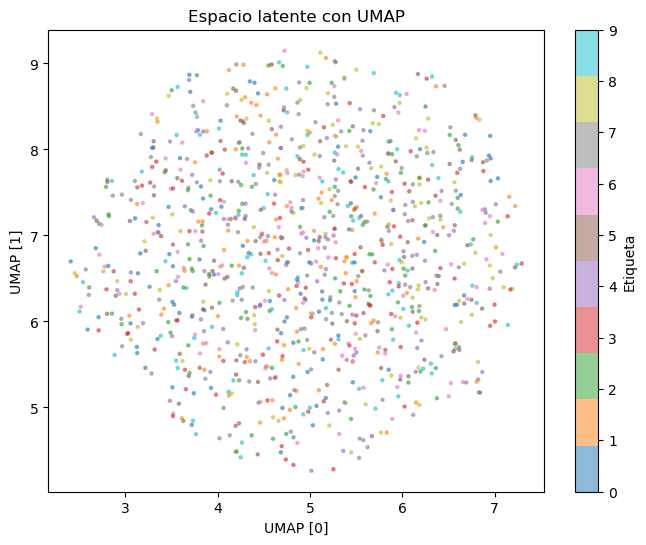

In [ ]:
import visualizaciones.visualizar as vis
import tensorflow as tf

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
vis.latent_space_umap(cvae_0, val_dataset, 1000, save_path="esapacio_latente_dim_2.png")
vis.latent_space_umap(
    cvae_1, val_dataset, 1000, save_path="esapacio_latente_dim_128.png"
)

Se pueden observar clusters bien definidos en el primer modelo, no así en el segundo (peores reconstrucciones)


In [8]:
import matplotlib.pyplot as plt

# Tus datos


def plot_error(resultados, ruta):
    valores = list(resultados.values())
    claves = list(resultados.keys())

    # Graficar barras
    bars = plt.bar(claves, valores)

    # Etiquetas encima de cada barra
    for i, bar in enumerate(bars):
        altura = bar.get_height()
        color_fondo = bar.get_facecolor()

        # Elegir blanco o negro según luminosidad del color de la barra
        r, g, b, _ = color_fondo
        color_texto = "black"

        plt.text(
            bar.get_x() + bar.get_width() / 2,  # centrado horizontal
            altura + 0.0015,  # un poco abajo del tope de la barra
            f"{valores[i]:.3f}",
            ha="center",
            va="top",
            color=color_texto,
            fontsize=10,
        )

    plt.xlabel("Dígito")
    plt.ylabel("Error de reconstrucción [MSE]")
    plt.title("Reconstrucción promedio por clase")
    plt.tight_layout()
    plt.savefig(f"{ruta}.png")
    plt.show()


"""
quizas el error tiene que ver con la variabilidad de cada dígito ("mas formas de dibujar un 8 que mas formas de dibjuar un 1")
¿Como aprovehcar esto para mejorar el aprendizaje?
tal vez se pueda ponderar la loss de reconstruccion en funcion del dígito 
coeficinetes (al principio en 1)->una epoca-> validacion comparando contra estos valores-> ajuste-> epocas---> se "aplana"  este grafico 
el error.
"""

'\nquizas el error tiene que ver con la variabilidad de cada dígito ("mas formas de dibujar un 8 que mas formas de dibjuar un 1")\n¿Como aprovehcar esto para mejorar el aprendizaje?\ntal vez se pueda ponderar la loss de reconstruccion en funcion del dígito \ncoeficinetes (al principio en 1)->una epoca-> validacion comparando contra estos valores-> ajuste-> epocas---> se "aplana"  este grafico \nel error.\n'

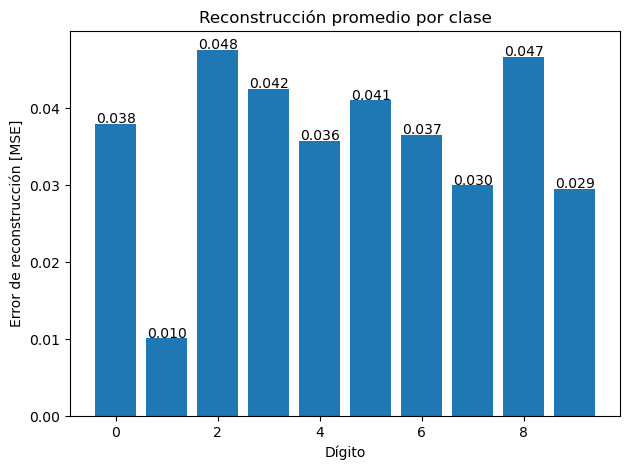

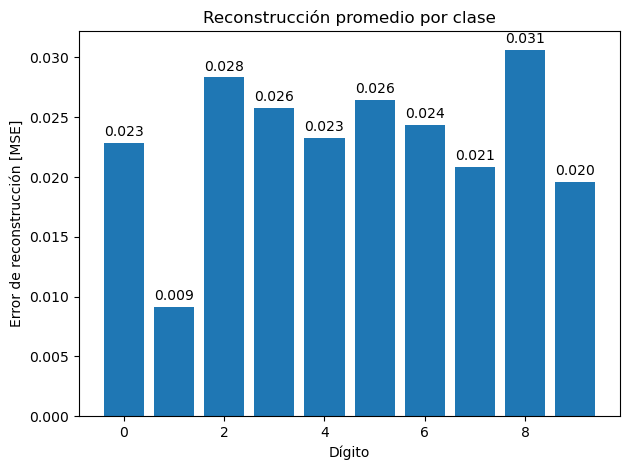

In [ ]:
plot_error(resultados=resultados_0, ruta="128_2_MSE_variaciones")
plot_error(resultados=resultados_1, ruta="256_128_MSE_variaciones")

Ambos modelos se comportan de maneras muy similiar, practicamente identicos. --> ¿Es necesario tener modelos tan grandes para esta tarea?

- El bajo error en la reconstrucción del dígito 1 ¿Tendra que ver con la poca "dispersión o variabilidad" para dibujar el número? --> El numero 2 y 8 son los que más error tienen, ¿Más formas de dibujar estos números?
